# Week 7 KNN

#### In this lab you will learn how to use sklearn to build a machine learning model using k‑Nearest Neighbors algorithm to predict whether the patients in the "Pima Indians Diabetes Dataset" have diabetes or not.
#### The dataset that we'll be using for this task comes from kaggle.com and contains the following attributes:- Pregnancies: Number of times pregnant- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2‑Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age (in years)
- Outcome: Class variable (0 or 1)

### Exploratory Data Analysis

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 5
sns.set_style('darkgrid')

In [32]:
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [33]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Looking at the info summary, we can see that there are 768 entries in the DataFrame, and 768 non‑null entries in each
feature/colum. Thus, there are no missing values, but there is something strange when we look at the describe summary below.
For certain columns below, does a value of zero make sense? For example, if an individual had a glucose or blood pressure level of
0, they'd probably be dead, so it's likely that the true values were excluded from the data for some reason.
Therefore, we'll consider the following columns to have missing values where there's an invalid zero value

In [34]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Let's go ahead and replace out invalid zero values with nan, since they technically missing values. We'll go ahead and make a copy
of our diabetes_df and modify the zeros in the copy just incase we need to refer back to the original. We can make copies of
DataFrames using .copy(deep=True). There's also a very convenient function we can call .replace(x, y) that will replace all x
values with the y value specified

In [35]:
diabetes_df_copy = diabetes_df.copy(deep=True)
diabetes_df_copy['Glucose'] = diabetes_df_copy['Glucose'].replace(0,np.nan)
diabetes_df_copy['BloodPressure'] = diabetes_df_copy['BloodPressure'].replace(0,np.nan)
diabetes_df_copy['SkinThickness'] = diabetes_df_copy['SkinThickness'].replace(0,np.nan)
diabetes_df_copy['Insulin'] = diabetes_df_copy['Insulin'].replace(0,np.nan)
diabetes_df_copy['BMI'] = diabetes_df_copy['BMI'].replace(0,np.nan)

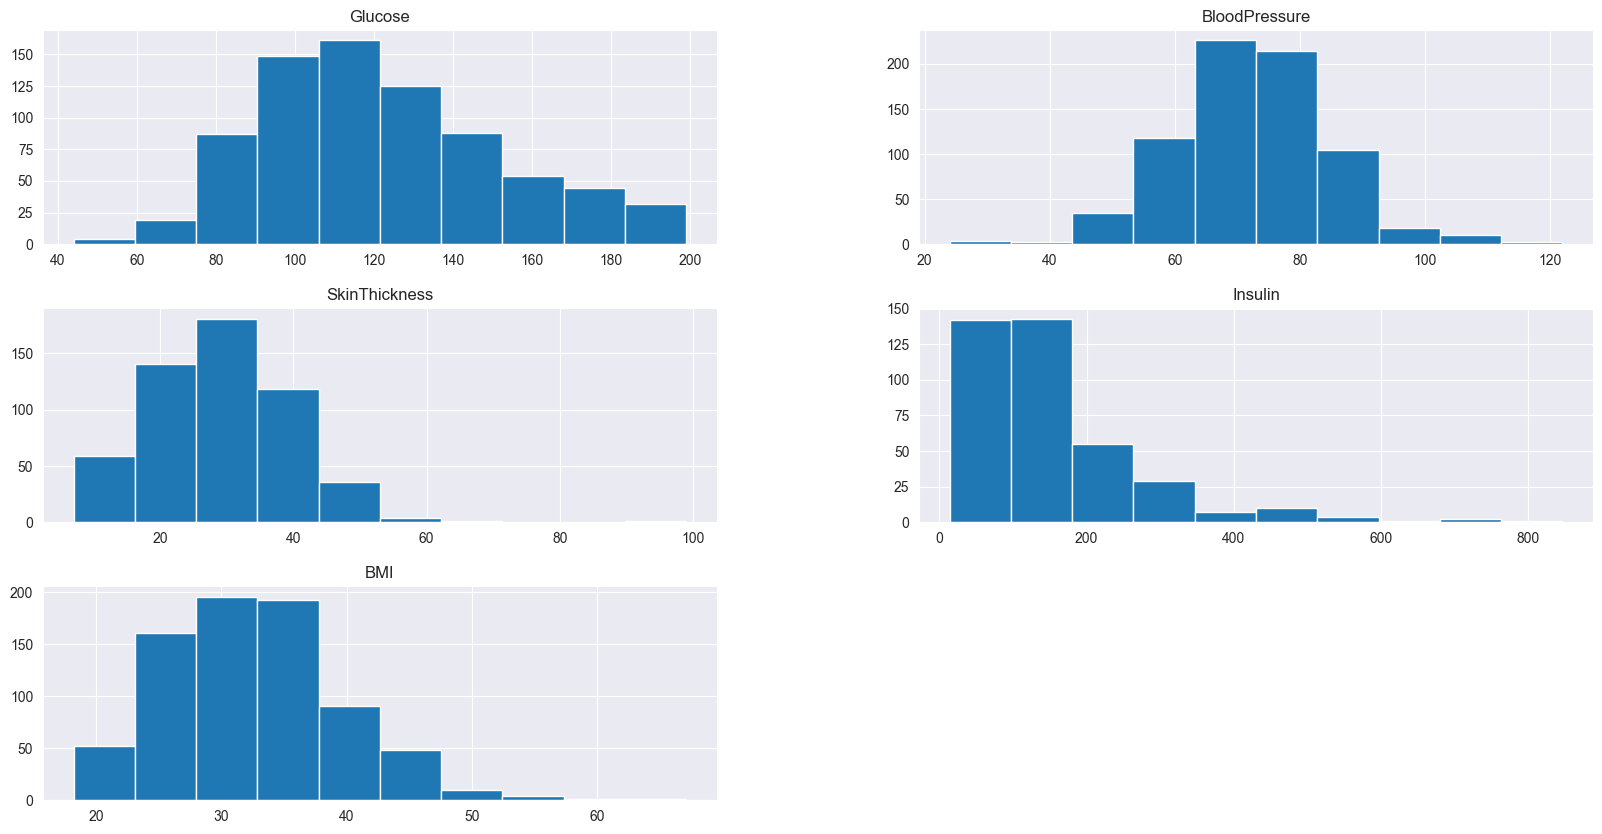

In [36]:
diabetes_df_copy[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].hist(figsize = (20,10))
plt.show()

Since SkinThickness, Insulin, and BMI look skewed, we'll go ahead and replace their missing values with median instead of mean.
Glucose and BloodPressure should be ok if we stick with mean for imputing. Recall that mean can be effected by outliers

In [37]:
diabetes_df_copy['Glucose'].fillna(diabetes_df_copy['Glucose'].mean(), inplace = True)
diabetes_df_copy['BloodPressure'].fillna(diabetes_df_copy['BloodPressure'].mean(), inplace = True)
diabetes_df_copy['SkinThickness'].fillna(diabetes_df_copy['SkinThickness'].median(), inplace = True)
diabetes_df_copy['Insulin'].fillna(diabetes_df_copy['Insulin'].median(), inplace = True)
diabetes_df_copy['BMI'].fillna(diabetes_df_copy['BMI'].median(), inplace = True)


C:\Users\Bebe\AppData\Local\Temp\ipykernel_21372\921599098.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diabetes_df_copy['Glucose'].fillna(diabetes_df_copy['Glucose'].mean(), inplace = True)
C:\Users\Bebe\AppData\Local\Temp\ipykernel_21372\921599098.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

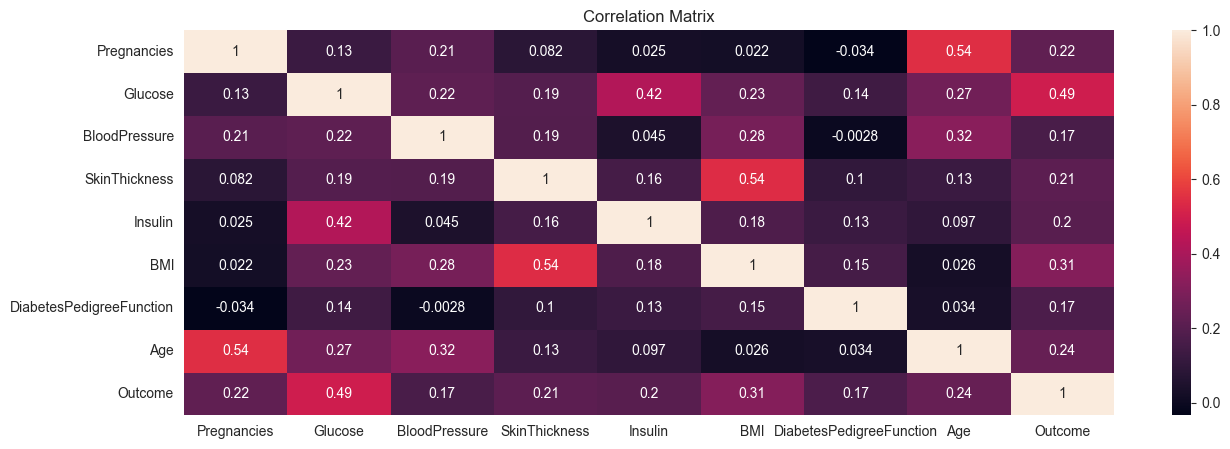

In [38]:
sns.heatmap(diabetes_df_copy.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

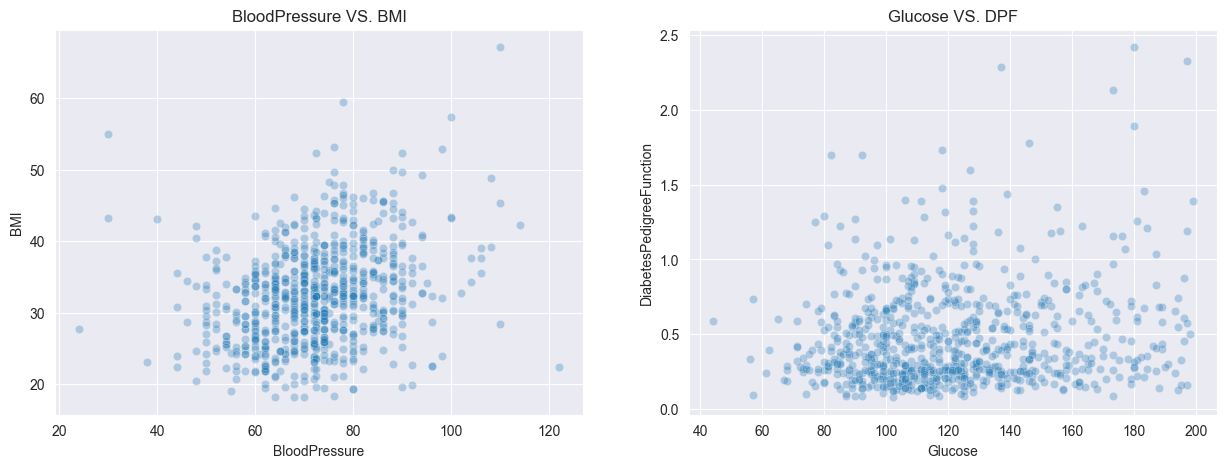

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# alpha parameter adjusts the point transparency. points with much more overlap will appear darker.
sns.scatterplot(x='BloodPressure', y='BMI', data=diabetes_df_copy, alpha=0.3, ax=axes[0])
axes[0].set_title('BloodPressure VS. BMI')
sns.scatterplot(x='Glucose', y='DiabetesPedigreeFunction', data=diabetes_df_copy, alpha=0.3, ax=axes[1])
axes[1].set_title('Glucose VS. DPF')
plt.show()

### Different examples

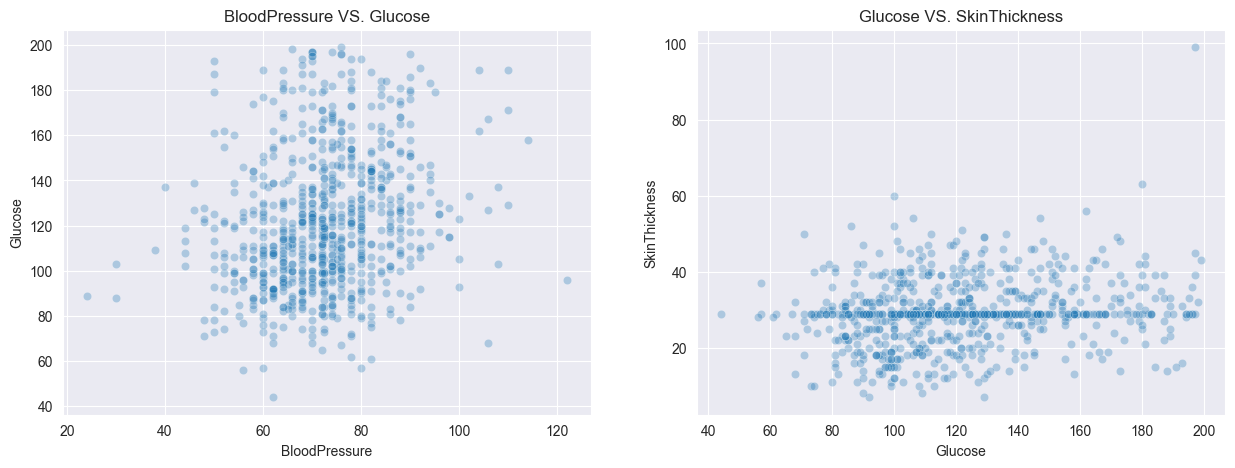

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# alpha parameter adjusts the point transparency. points with much more overlap will appear darker.
sns.scatterplot(x='BloodPressure', y='Glucose', data=diabetes_df_copy, alpha=0.3, ax=axes[0])
axes[0].set_title('BloodPressure VS. Glucose')
sns.scatterplot(x='Glucose', y='SkinThickness', data=diabetes_df_copy, alpha=0.3, ax=axes[1])
axes[1].set_title('Glucose VS. SkinThickness')
plt.show()

Interpretation:
BMI seems to have a slight increase as blood pressure increases. However, majority of the data seems to be centered and
cluster at around a blood pressure of 50‑95 and BMI of 20‑45. We've also got some outliars scattered around the main
cluster.
There's a very subtle increase in diabetes pedigree function as glucose increases. Majority of the data tends to fall between a
75 and 175 glucose level. We also have some outliars with very high diabetes pedigree function and again the zeros outliars
which were removed in the no_zeros_df

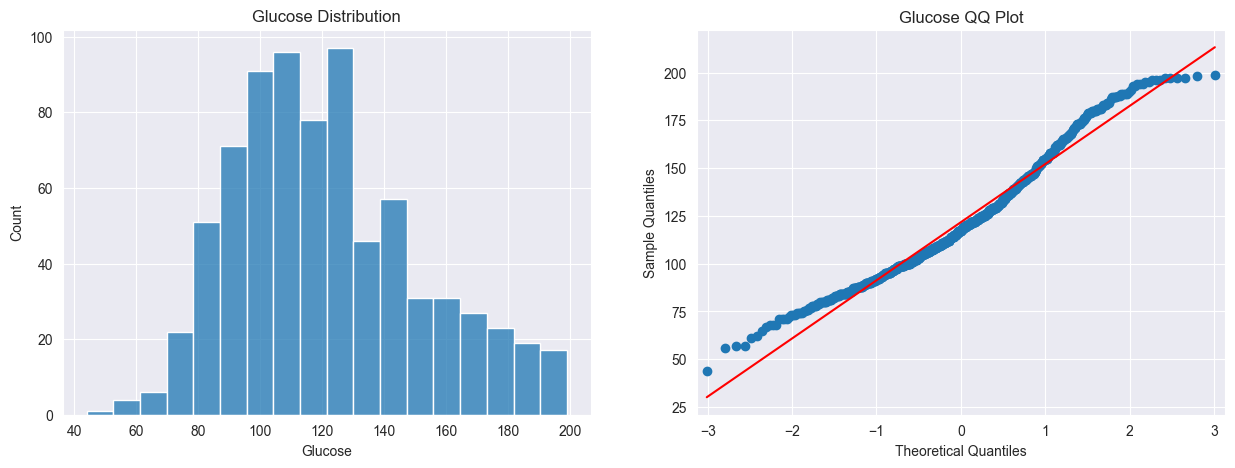

ShapiroWilk: 
w:0.9699018329062374, pvalue: 1.7768159864571322e-11

KolmogorovSmirnov: 
d:0.9699018329062374, pvalue: 0.0

Skewness of the data: 
0.531677628850459



In [41]:
import statsmodels.api as sm
import scipy
import pylab
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.histplot(diabetes_df_copy['Glucose'], ax=axes[0])
axes[0].set_title('Glucose Distribution')
sm.qqplot(diabetes_df_copy['Glucose'], line='s', ax=axes[1])
axes[1].set_title('Glucose QQ Plot' )
pylab.show()
w, p_val = scipy.stats.shapiro(diabetes_df_copy['Glucose'])
print('ShapiroWilk: \nw:{}, pvalue: {}\n'.format(w,p_val))
d, p_val = scipy.stats.kstest(diabetes_df_copy['Glucose'], 'norm')
print('KolmogorovSmirnov: \nd:{}, pvalue: {}\n'.format(w,p_val))
print('Skewness of the data: \n{}\n'.format(scipy.stats.skew(diabetes_df_copy['Glucose'])))

### Different example

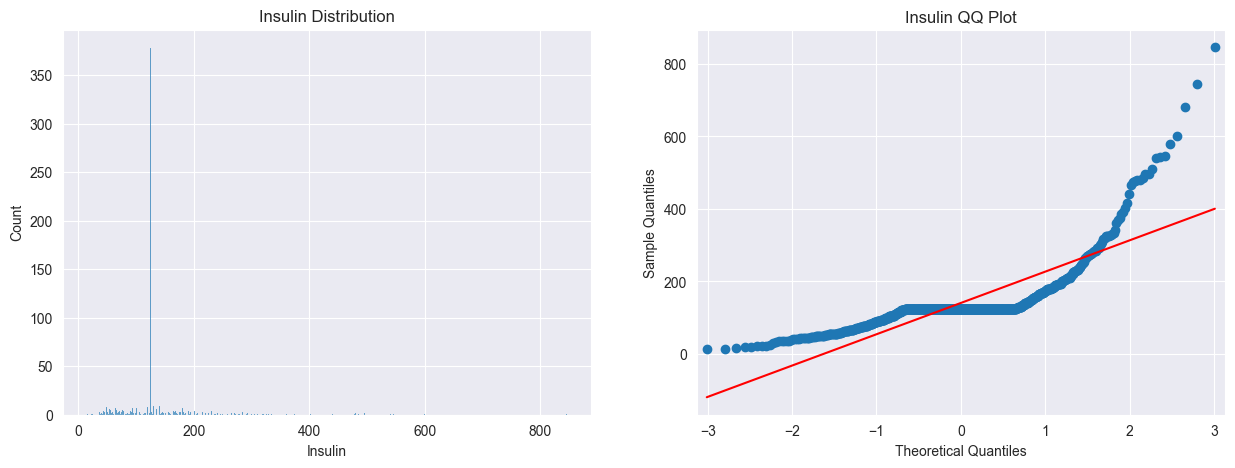

ShapiroWilk: 
w:0.6415107522087105, pvalue: 3.3709011423382157e-37

KolmogorovSmirnov: 
d:0.6415107522087105, pvalue: 0.0

Skewness of the data: 
3.3734139434873414



In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.histplot(diabetes_df_copy['Insulin'], ax=axes[0])
axes[0].set_title('Insulin Distribution')
sm.qqplot(diabetes_df_copy['Insulin'], line='s', ax=axes[1])
axes[1].set_title('Insulin QQ Plot' )
pylab.show()
w2, p2_val = scipy.stats.shapiro(diabetes_df_copy['Insulin'])
print('ShapiroWilk: \nw:{}, pvalue: {}\n'.format(w2,p2_val))
d2, p2_val = scipy.stats.kstest(diabetes_df_copy['Insulin'], 'norm')
print('KolmogorovSmirnov: \nd:{}, pvalue: {}\n'.format(w2,p2_val))
print('Skewness of the data: \n{}\n'.format(scipy.stats.skew(diabetes_df_copy['Insulin'])))

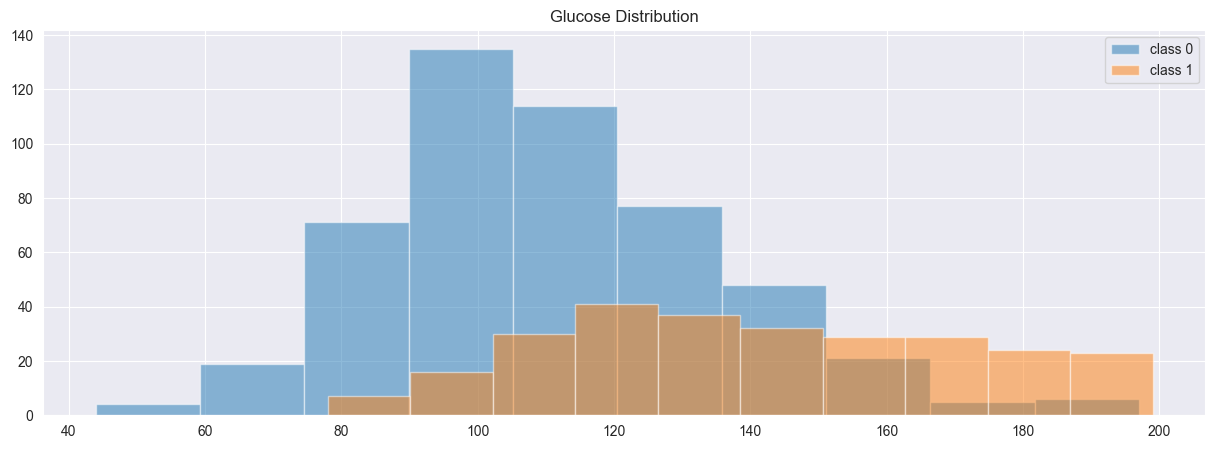

In [43]:
class_zero = diabetes_df_copy[(diabetes_df_copy['Outcome'] == 0)]
class_one = diabetes_df_copy[(diabetes_df_copy['Outcome'] == 1)]
plt.hist(x=class_zero['Glucose'], label='class 0', alpha=0.5)
plt.hist(x=class_one['Glucose'], label='class 1', alpha=0.5)
plt.legend()
plt.title('Glucose Distribution')
plt.show()

### Different examples

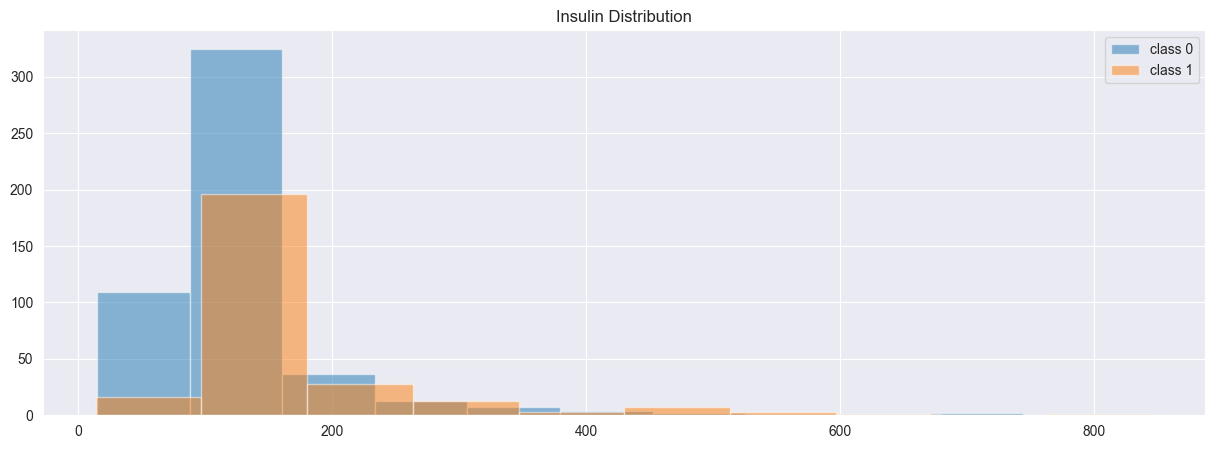

In [44]:
class_zero2 = diabetes_df_copy[(diabetes_df_copy['Outcome'] == 0)]
class_one2 = diabetes_df_copy[(diabetes_df_copy['Outcome'] == 1)]
plt.hist(x=class_zero2['Insulin'], label='class 0', alpha=0.5)
plt.hist(x=class_one2['Insulin'], label='class 1', alpha=0.5)
plt.legend()
plt.title('Insulin Distribution')
plt.show()

### Pre Processing

In [45]:
from sklearn.preprocessing import StandardScaler
# all columns except 'Outcome'
X = diabetes_df_copy.drop('Outcome', axis=1)
y = diabetes_df_copy['Outcome']
# create our scaler object
scaler = StandardScaler()
# use our scaler object to transform/scale our data and save it into X_scaled
X_scaled = scaler.fit_transform(X)
# reassign X to a new DataFrame using the X_scaled values.
X = pd.DataFrame(data=X_scaled, columns=X.columns)

In [46]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,0.670643,-0.181541,0.166619,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,1.233880,2.015813,-0.695306,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,-0.844885,-1.074652,-0.529859,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,-1.141852,0.503458,-2.680669,0.670643,0.316566,1.549303,5.484909,-0.020496


### Different examples

In [47]:

X2 = diabetes_df_copy.drop('Insulin', axis=1)
y2= diabetes_df_copy['Insulin']
# create our scaler object
scaler2 = StandardScaler()
# use our scaler object to transform/scale our data and save it into X_scaled
X2_scaled = scaler2.fit_transform(X2)
# reassign X to a new DataFrame using the X_scaled values.
X2 = pd.DataFrame(data=X2_scaled, columns=X2.columns)

In [48]:
X2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.865108,-0.033518,0.670643,0.166619,0.468492,1.425995,1.365896
1,-0.844885,-1.206162,-0.529859,-0.012301,-0.852200,-0.365061,-0.190672,-0.732120
2,1.233880,2.015813,-0.695306,-0.012301,-1.332500,0.604397,-0.105584,1.365896
3,-0.844885,-1.074652,-0.529859,-0.695245,-0.633881,-0.920763,-1.041549,-0.732120
4,-1.141852,0.503458,-2.680669,0.670643,1.549303,5.484909,-0.020496,1.365896


### Creating our model

We're now ready to begin creating and training our model. We first need to split our data into training and testing sets. This can be
done using sklearn's train_test_split(X, y, test_size) function. This function takes in your features (X), the target variable (y), and
the test_size you'd like (Generally a test size of around 0.3 is good enough). It will then return a tuple of X_train, X_test, y_train,
y_test sets for us. We will train our model on the training set and then use the test set to evaluate the model.

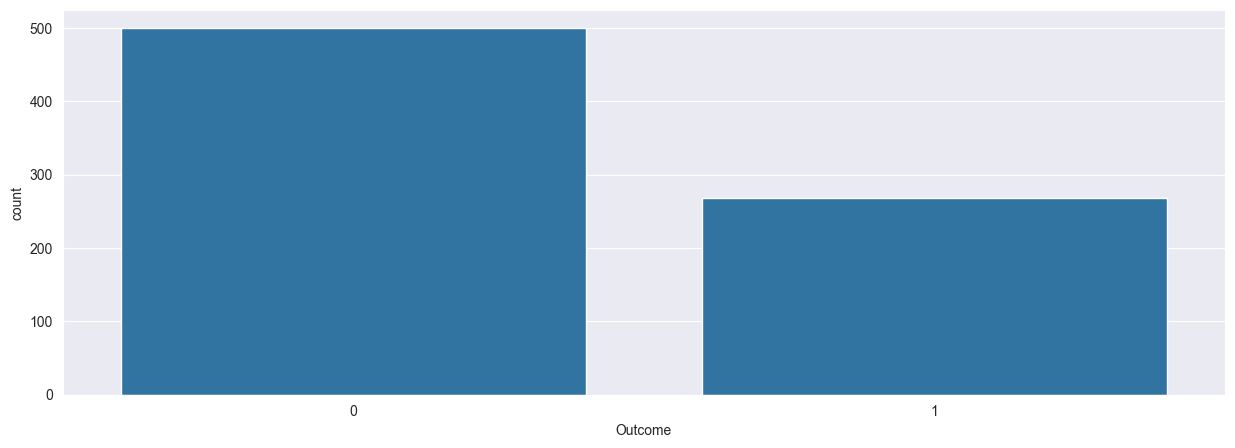

In [49]:
sns.countplot(x=diabetes_df_copy['Outcome'])
plt.show()

The above graph shows that the data is biased towards datapoints having outcome value as 0 (diabetes was not present actually).
The number of non‑diabetics is almost twice the number of diabetic patients. This is where an additional parameter stratify can
come in handy. Stratified sampling aims at splitting a data set so that each split is similar with respect to something. In a
classification setting, it is often chosen to ensure that the train and test sets have approximately the same percentage of samples
of each target class as the complete set

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
# will append scores here for plotting later
test_scores = []
train_scores = []
# testing k values from 114
for i in range(1,15):
    # create a model with k=i
    knn = KNeighborsClassifier(i)
    # train the model
    knn.fit(X_train,y_train)
    # append scores.
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

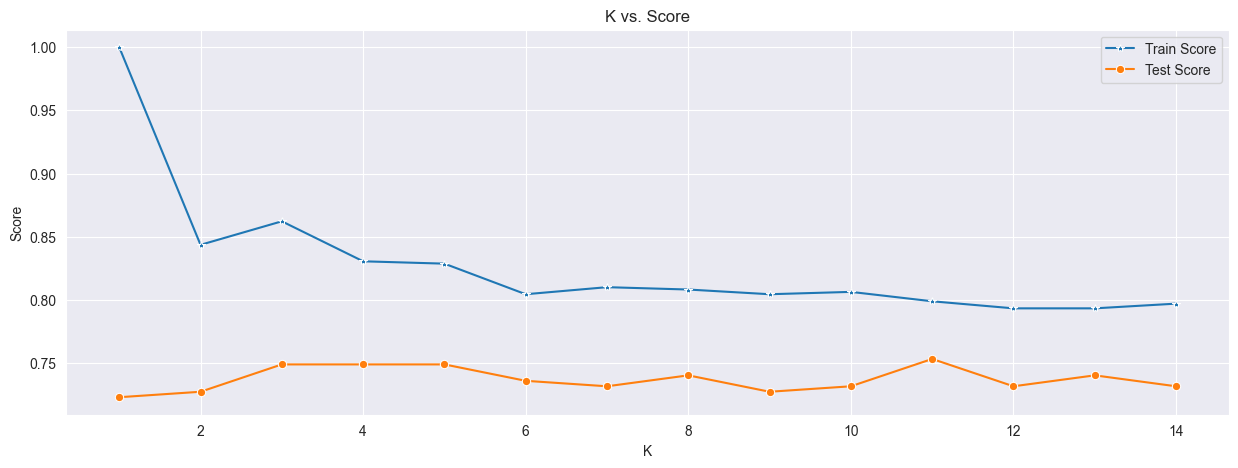

In [52]:
sns.lineplot(x=range(1,15), y=train_scores, marker='*', label='Train Score')
sns.lineplot(x=range(1,15), y=test_scores, marker='o', label='Test Score')
plt.title('K vs. Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

In [53]:
knn = KNeighborsClassifier(11)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7532467532467533

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       150
           1       0.67      0.58      0.62        81

    accuracy                           0.75       231
   macro avg       0.73      0.71      0.72       231
weighted avg       0.75      0.75      0.75       231

[[127  23]
 [ 34  47]]


### Different examples

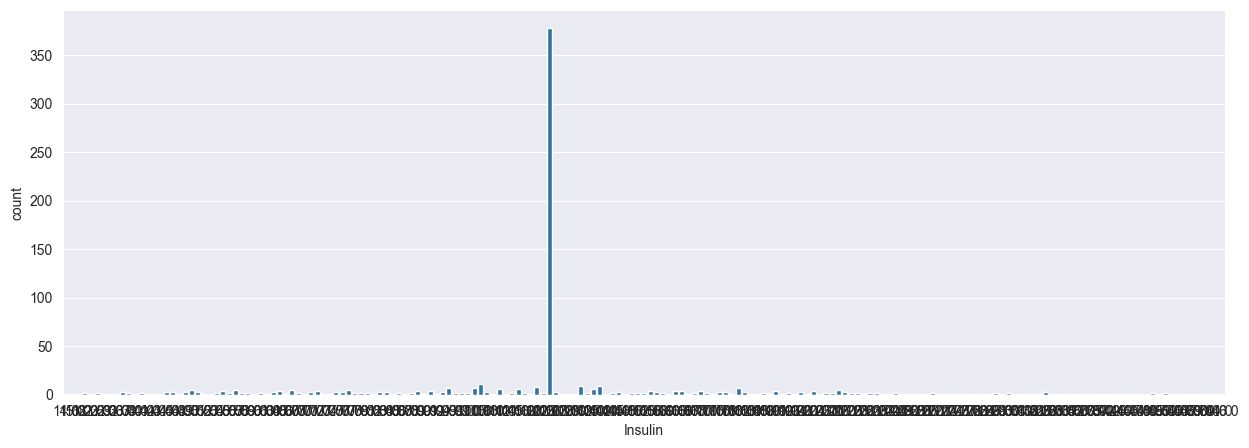

In [55]:
sns.countplot(x=diabetes_df_copy['Insulin'])
plt.show()

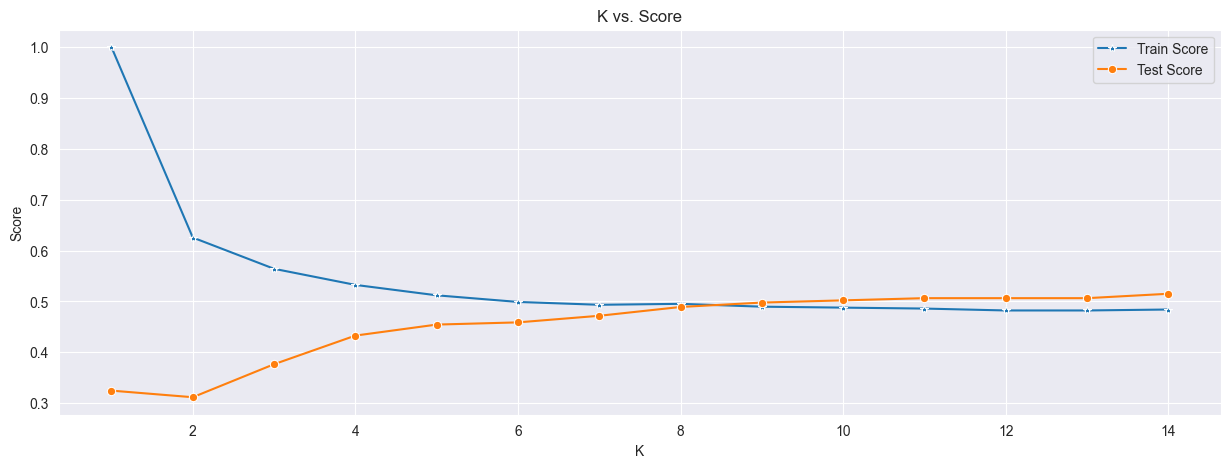

In [56]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y, random_state=42)

# will append scores here for plotting later
test_scores2 = []
train_scores2 = []
# testing k values from 114
for i in range(1,15):
    # create a model with k=i
    knn2 = KNeighborsClassifier(i)
    # train the model
    knn2.fit(X2_train,y2_train)
    # append scores.
    train_scores2.append(knn2.score(X2_train,y2_train))
    test_scores2.append(knn2.score(X2_test,y2_test))
    
sns.lineplot(x=range(1,15), y=train_scores2, marker='*', label='Train Score')
sns.lineplot(x=range(1,15), y=test_scores2, marker='o', label='Test Score')
plt.title('K vs. Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

In [57]:
knn2 = KNeighborsClassifier(11)
knn2.fit(X2_train,y2_train)
knn2.score(X2_test,y2_test)

0.5064935064935064

In [58]:
y_pred2 = knn2.predict(X2_test)
print(classification_report(y2_test,y_pred2))
print(confusion_matrix(y2_test,y_pred2))

              precision    recall  f1-score   support

        14.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        23.0       0.00      0.00      0.00         1
        29.0       0.00      0.00      0.00         0
        37.0       0.00      0.00      0.00         1
        42.0       0.00      0.00      0.00         0
        43.0       0.00      0.00      0.00         0
        44.0       0.00      0.00      0.00         1
        45.0       0.00      0.00      0.00         2
        48.0       0.00      0.00      0.00         0
        49.0       0.00      0.00      0.00         1
        50.0       0.00      0.00      0.00         1
        53.0       0.00      0.00      0.00         1
        54.0       0.00      0.00      0.00         2
        55.0       0.00      0.00      0.00         1
        56.0       0.00      0.00      0.00         2
        57.0       0.00      0.00      0.00         1
        58.0       0.00    

c:\Users\Bebe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Bebe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Bebe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{